In [4]:
pip install opencv-python dlib imutils


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install face_recognition


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=6a8c762e1e81b3e0c68ce82437ec941bcc4bae4dbf60bb39af21ea9d347b9b2d
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


**Cropping Faces**

In [ ]:
import os
import cv2
import dlib
from imutils import face_utils

# Define the face detector
face_detector = dlib.get_frontal_face_detector()

# Define the path to the main directory containing student subfolders
main_directory = '/content/drive/MyDrive/Photos'

# Define the path to the directory where the cropped faces will be stored
output_directory = '/content/drive/MyDrive/resized_photos'

# Make the output directory if it doesn't already exist
os.makedirs(output_directory, exist_ok=True)

# Loop over all subfolders in the main directory
for student_folder in os.listdir(main_directory):
    student_folder_path = os.path.join(main_directory, student_folder)

    # Continue if not a directory
    if not os.path.isdir(student_folder_path):
        continue

    # Loop over all files in the student subfolder
    for filename in os.listdir(student_folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"): # Add/modify according to your image type
            # Load the image using OpenCV
            img = cv2.imread(os.path.join(student_folder_path, filename))

            # Convert the image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Detect faces in the grayscale image
            rects = face_detector(gray, 1)

            # Loop over each face detected in the image
            for (i, rect) in enumerate(rects):
                # Convert the face rectangle to a bounding box
                (x, y, w, h) = face_utils.rect_to_bb(rect)

                # Let's add some padding around the face bounding box for capturing more context
                padding = 20 # Adjust this value based on your requirements
                (x, y, w, h) = max(x - padding, 0), max(y - padding, 0), w + padding, h + padding

                # Crop the face out of the image (ensure coordinates are within image bounds)
                face = img[y:min(y + h, img.shape[0]), x:min(x + w, img.shape[1])]

                # Resize the face to desired size
                face_resized = cv2.resize(face, (256, 256))

                # Define the output subfolder path
                output_subfolder_path = os.path.join(output_directory, student_folder)

                # Make the output subfolder if it doesn't already exist
                os.makedirs(output_subfolder_path, exist_ok=True)

                # Save the cropped face
                cv2.imwrite(os.path.join(output_subfolder_path, f"{filename.split('.')[0]}_face_{i}.jpg"), face_resized)


**DATA AUGMENTATION: Guassian blur, Flipping, Normalization**

In [ ]:
import cv2
import numpy as np
import os
from PIL import Image
from PIL import ImageEnhance

# Training directory
train_dir = os.path.join("/content/drive/MyDrive/resized_photos")

# Loop through each person in the training directory
for person in os.listdir(train_dir):
    pix = os.listdir(os.path.join(train_dir, person))

    # Loop through each training image for the current person
    for person_img in pix:
        # Load the image
        img_path = os.path.join(train_dir, person, person_img)
        img = cv2.imread(img_path)

        # Gaussian blur
        blur = cv2.GaussianBlur(img, (5, 5), 0)
        cv2.imwrite(os.path.join(train_dir, person, "blur_" + person_img), blur)

        # Image flip
        flip = cv2.flip(img, 1)
        cv2.imwrite(os.path.join(train_dir, person, "flip_" + person_img), flip)

        # Illuminance normalization using PIL
        pil_img = Image.open(img_path)
        enhancer = ImageEnhance.Brightness(pil_img)
        normalized_img = enhancer.enhance(1.8)  # Increase brightness
        normalized_img.save(os.path.join(train_dir, person, "normalized_" + person_img))


**TRAINING & TESTING MODEL**

**SVM:**

In [7]:
import os
import face_recognition
from sklearn import svm

# Training the SVC classifier

# The training data would be all the face encodings from all the known images and the labels are their names
encodings = []
names = []

# Training directory
train_dir = os.path.join("/content/drive/MyDrive/resized_photos")

# Loop through each person in the training directory
for person in os.listdir(train_dir):
    pix = os.listdir(os.path.join(train_dir, person))

    # Loop through each training image for the current person
    for person_img in pix:
        # Get the face encodings for the face in each image file
        face = face_recognition.load_image_file(os.path.join(train_dir, person, person_img))
        face_bounding_boxes = face_recognition.face_locations(face)

        #If training image contains exactly one face
        if len(face_bounding_boxes) == 1:
            face_enc = face_recognition.face_encodings(face)[0]
            # Add face encoding for current image with corresponding label (name) to the training data
            encodings.append(face_enc)
            names.append(person)
        else:
            print(person + "/" + person_img + " was skipped and can't be used for training")

# Create and train the SVC classifier
clf = svm.SVC(gamma='scale')
clf.fit(encodings,names)



Rohan Vikas Lagare/lagarerohanvikas_63551_6937153_cropped_pic_Rohan_Lagare_face_0.jpg was skipped and can't be used for training
Rohan Vikas Lagare/blur_lagarerohanvikas_63551_6937153_cropped_pic_Rohan_Lagare_face_0.jpg was skipped and can't be used for training
Rohan Vikas Lagare/flip_lagarerohanvikas_63551_6937153_cropped_pic_Rohan_Lagare_face_0.jpg was skipped and can't be used for training
Rohan Vikas Lagare/normalized_lagarerohanvikas_63551_6937153_cropped_pic_Rohan_Lagare_face_0.jpg was skipped and can't be used for training
Tampara Venkata Santosh Anish Dora/doratamparavenkatasantoshanish_70986_6989584_1682031833_face_0.jpg was skipped and can't be used for training
Tampara Venkata Santosh Anish Dora/blur_doratamparavenkatasantoshanish_70986_6989584_1682031833_face_0.jpg was skipped and can't be used for training
Tampara Venkata Santosh Anish Dora/normalized_doratamparavenkatasantoshanish_70986_6989584_1682031833_face_0.jpg was skipped and can't be used for training
Landis Fusat

SVC()

Kai Cong/congkai_71270_7068939_0502kaicong2.jpg doesn't contain any faces.
Bowen Cheng/chengbowen_71300_7114284_1684816218630.jpg doesn't contain any faces.
Accuracy:  0.9523809523809523
                                    precision    recall  f1-score   support

                     Abdullah Khan       1.00      1.00      1.00         1
                      Akshat Kalra       1.00      1.00      1.00         4
                       Bowen Cheng       1.00      1.00      1.00         1
                Chakrapani Chitnis       1.00      1.00      1.00         3
                     Chin Fang Hsu       0.00      0.00      0.00         0
                    Edison Nalluri       1.00      1.00      1.00         4
                          Kai Cong       1.00      1.00      1.00         4
                       Kyle Fenole       1.00      1.00      1.00         7
                     Landis Fusato       1.00      1.00      1.00         3
                     Minghao Zhang       0.00      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

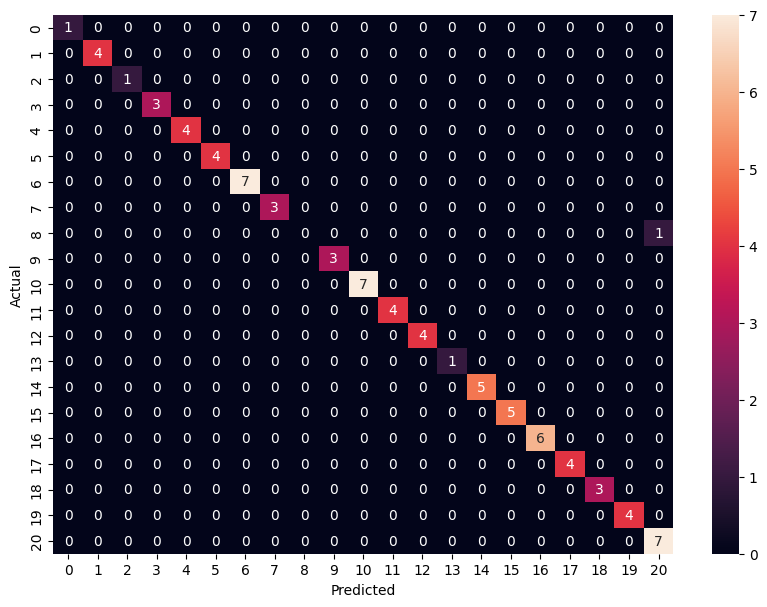

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Testing directory
test_dir = os.path.join("/content/drive/MyDrive/Testing_Photos")

# Loop through each person in the testing directory
test_encodings = []
test_names = []
for person in os.listdir(test_dir):
    if person == ".DS_Store":
        continue
    person_dir = os.path.join(test_dir, person)
    if os.path.isdir(person_dir):
        pix = os.listdir(person_dir)

        # Loop through each training image for the current person
        for person_img in pix:
            # Get the face encodings for the face in each image file
            face = face_recognition.load_image_file(os.path.join(person_dir, person_img))
            face_bounding_boxes = face_recognition.face_locations(face)

            # If there are faces in the image
            if len(face_bounding_boxes) >= 1:
                # Iterate over each face in the image
                for i in range(len(face_bounding_boxes)):
                    face_enc = face_recognition.face_encodings(face)[i]
                    # Add face encoding for current image with corresponding label (name) to the training data
                    test_encodings.append(face_enc)
                    test_names.append(person)
            else:
                print(person + "/" + person_img + " doesn't contain any faces.")

# Predict labels for the test dataset
pred_names = clf.predict(test_encodings)

# Calculate accuracy
accuracy = accuracy_score(test_names, pred_names)
print("Accuracy: ", accuracy)

# Generate classification report
print(classification_report(test_names, pred_names))

# Generate confusion matrix
cm = confusion_matrix(test_names, pred_names, labels=np.unique(test_names))
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**K-NEAREST NEIGHBOURS**

Kai Cong/congkai_71270_7068939_0502kaicong2.jpg doesn't contain any faces.
Bowen Cheng/chengbowen_71300_7114284_1684816218630.jpg doesn't contain any faces.
Accuracy:  0.7380952380952381
                                    precision    recall  f1-score   support

                     Abdullah Khan       1.00      1.00      1.00         1
                      Akshat Kalra       1.00      1.00      1.00         4
                       Bowen Cheng       0.50      1.00      0.67         1
                Chakrapani Chitnis       0.60      1.00      0.75         3
                    Edison Nalluri       1.00      1.00      1.00         4
                          Kai Cong       0.00      0.00      0.00         4
                       Kyle Fenole       0.00      0.00      0.00         7
                     Landis Fusato       1.00      1.00      1.00         3
                     Minghao Zhang       1.00      1.00      1.00         4
                      Mohit Jawale       1.00      1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


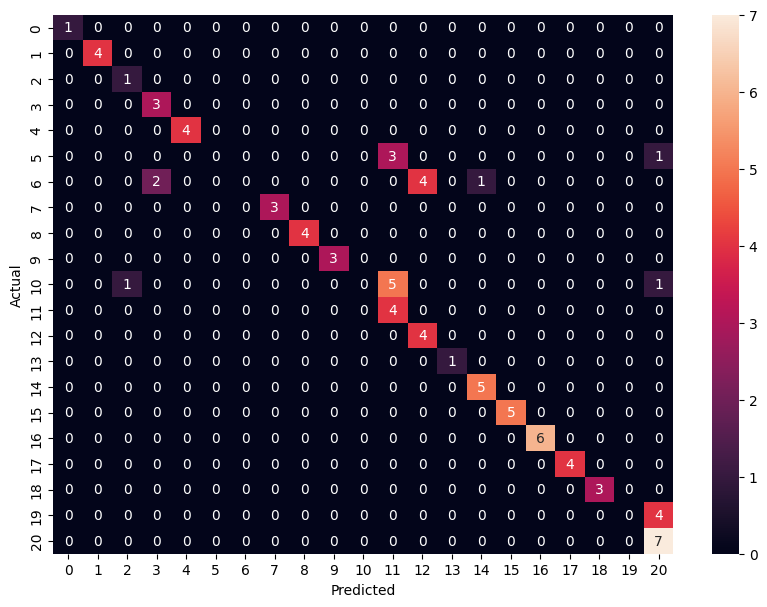

In [ ]:
# Create and train the kNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(encodings, names)



# Testing directory
test_dir = os.path.join("/content/drive/MyDrive/Testing_Photos")

# Loop through each person in the testing directory
test_encodings = []
test_names = []
for person in os.listdir(test_dir):
    if person == ".DS_Store":
        continue
    person_dir = os.path.join(test_dir, person)
    if os.path.isdir(person_dir):
        pix = os.listdir(person_dir)

        # Loop through each training image for the current person
        for person_img in pix:
            # Get the face encodings for the face in each image file
            face = face_recognition.load_image_file(os.path.join(person_dir, person_img))
            face_bounding_boxes = face_recognition.face_locations(face)

            # If there are faces in the image
            if len(face_bounding_boxes) >= 1:
                # Iterate over each face in the image
                for i in range(len(face_bounding_boxes)):
                    face_enc = face_recognition.face_encodings(face)[i]
                    # Add face encoding for current image with corresponding label (name) to the training data
                    test_encodings.append(face_enc)
                    test_names.append(person)
            else:
                print(person + "/" + person_img + " doesn't contain any faces.")

# Predict labels for the test dataset
pred_names = knn.predict(test_encodings)

# Calculate accuracy
accuracy = accuracy_score(test_names, pred_names)
print("Accuracy: ", accuracy)

# Generate classification report
print(classification_report(test_names, pred_names))

# Generate confusion matrix
cm = confusion_matrix(test_names, pred_names, labels=np.unique(test_names))
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**RANDOM FOREST**

Kai Cong/congkai_71270_7068939_0502kaicong2.jpg doesn't contain any faces.
Bowen Cheng/chengbowen_71300_7114284_1684816218630.jpg doesn't contain any faces.
Accuracy:  0.7142857142857143
                                    precision    recall  f1-score   support

                     Abdullah Khan       1.00      1.00      1.00         1
                      Akshat Kalra       1.00      1.00      1.00         4
                       Bowen Cheng       0.33      1.00      0.50         1
                Chakrapani Chitnis       1.00      1.00      1.00         3
                    Edison Nalluri       1.00      1.00      1.00         4
                          Kai Cong       0.00      0.00      0.00         4
                       Kyle Fenole       0.00      0.00      0.00         7
                     Landis Fusato       0.75      1.00      0.86         3
                     Minghao Zhang       1.00      0.50      0.67         4
                      Mohit Jawale       1.00      1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


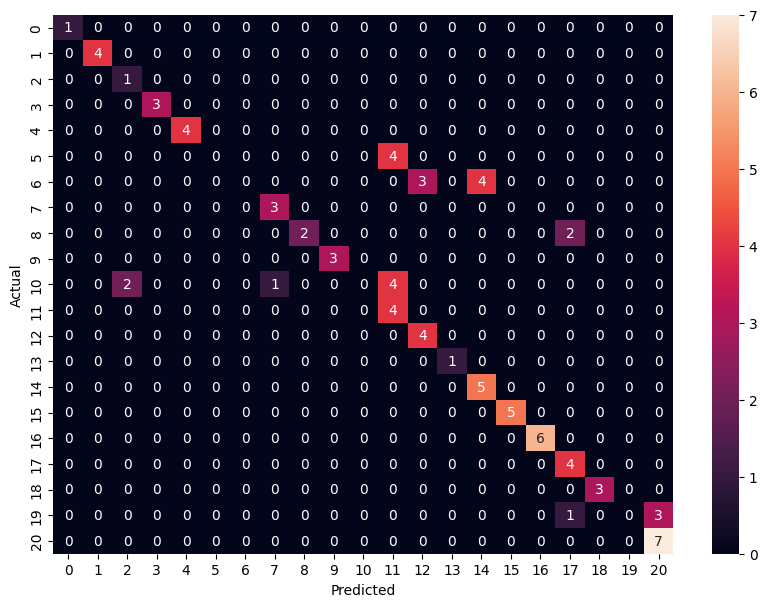

In [ ]:
# Create and train the Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(encodings, names)

# Testing directory
test_dir = os.path.join("/content/drive/MyDrive/Testing_Photos")

# Loop through each person in the testing directory
test_encodings = []
test_names = []
for person in os.listdir(test_dir):
    if person == ".DS_Store":
        continue
    person_dir = os.path.join(test_dir, person)
    if os.path.isdir(person_dir):
        pix = os.listdir(person_dir)

        # Loop through each training image for the current person
        for person_img in pix:
            # Get the face encodings for the face in each image file
            face = face_recognition.load_image_file(os.path.join(person_dir, person_img))
            face_bounding_boxes = face_recognition.face_locations(face)

            # If there are faces in the image
            if len(face_bounding_boxes) >= 1:
                # Iterate over each face in the image
                for i in range(len(face_bounding_boxes)):
                    face_enc = face_recognition.face_encodings(face)[i]
                    # Add face encoding for current image with corresponding label (name) to the training data
                    test_encodings.append(face_enc)
                    test_names.append(person)
            else:
                print(person + "/" + person_img + " doesn't contain any faces.")

# Predict labels for the test dataset
pred_names = rf.predict(test_encodings)

# Calculate accuracy
accuracy = accuracy_score(test_names, pred_names)
print("Accuracy: ", accuracy)

# Generate classification report
print(classification_report(test_names, pred_names))

# Generate confusion matrix
cm = confusion_matrix(test_names, pred_names, labels=np.unique(test_names))
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**XG BOOST**

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy:  0.9404761904761905
                                    precision    recall  f1-score   support

                     Abdullah Khan       1.00      1.00      1.00         1
                      Akshat Kalra       1.00      1.00      1.00         4
                       Bowen Cheng       0.50      1.00      0.67         1
                Chakrapani Chitnis       1.00      1.00      1.00         3
                     Chin Fang Hsu       0.00      0.00      0.00         0
                    Edison Nalluri       1.00      1.00      1.00         4
                          Kai Cong       1.00      1.00      1.00         4
                       Kyle Fenole       1.00      1.00      1.00         7
                     Landis Fusato       1.00      1.00      1.00         3
                     Minghao Zhang       0.00      0.00      0.00         4
                      Mohit Jawale       1.00      1.00      1.00         3
                       Patrick Lee       0.88      1.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

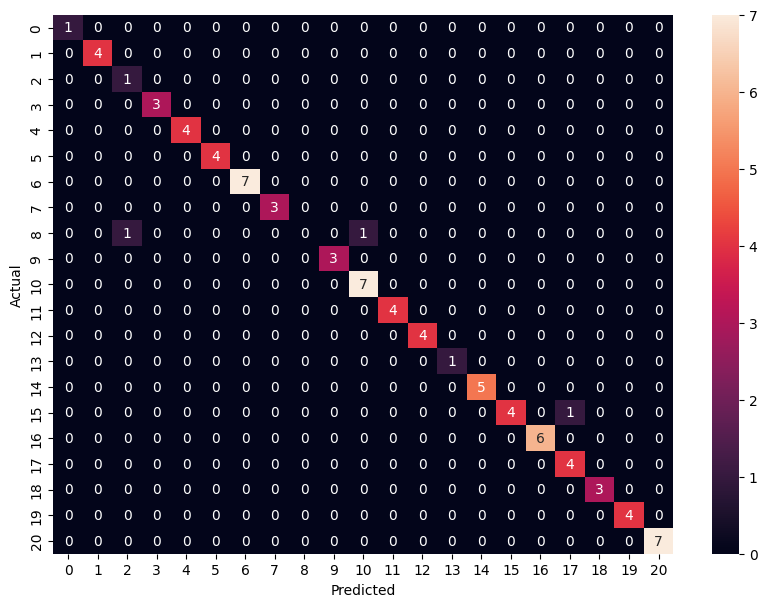

In [9]:
from xgboost import XGBClassifier

# Create and train the XGB classifier

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_names = le.fit_transform(names)

# then use encoded_names instead of names when fitting the model:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(encodings, encoded_names)


# make sure to inverse transform the predicted labels to get the original class labels:
pred_names_xgb_encoded = xgb.predict(test_encodings)
pred_names_xgb = le.inverse_transform(pred_names_xgb_encoded)


# Calculate accuracy
accuracy = accuracy_score(test_names, pred_names_xgb)
print("Accuracy: ", accuracy)

# Generate classification report
print(classification_report(test_names, pred_names_xgb))

# Generate confusion matrix
cm = confusion_matrix(test_names, pred_names_xgb, labels=np.unique(test_names))
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
